<a href="https://colab.research.google.com/github/ii200400/Tensorflow_Tutorial/blob/master/09%20-%20GAN/01_GAN(2_1ver).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 개요

비감독(Unsupervised) 학습 방법의 뜨거운 감자 GAN 구현

참고 링크\
https://www.tensorflow.org/tutorials/generative/dcgan

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 데이터 정의

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, _), (_, _) = mnist.load_data()

x_train = x_train.reshape(60000, 784).astype('float32') / 255

11493376/11490434 [==============================] - 0s 0us/step


## 모델 구성

### 신경망 구성

In [ ]:
n_hidden = 256
n_input = 28 * 28
n_noise = 128  # 생성기의 입력값으로 사용할 입력의 크기

# 생성기(G) 신경망 구성
def generator():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(n_hidden, activation='relu', use_bias=True, input_shape=(n_noise,)),
    tf.keras.layers.Dense(n_input, activation='sigmoid', use_bias=True)
  ])

  return model

# 판별기(D) 신경망 구성
def discriminator():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(n_hidden, activation='relu', use_bias=True, input_shape=(n_input,)),
    tf.keras.layers.Dense(1, activation='sigmoid', use_bias=True)
  ])

  return model

G = generator()
D = discriminator()

G.summary()
D.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               201488    
Total params: 234,512
Trainable params: 234,512
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 201,217
Trainable params: 201,217
Non-trainable params: 0
_________________________________________________________________


### 손실 함수

In [ ]:
learning_rate = 0.0002

# 크로스엔트로피 손실함수 (cross entropy loss)를 계산하기 위한 함수를 사용
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 감식자의 목표는 손실값은 진짜와 가짜 이미지를 잘 구별하는 것이다.
def discriminator_loss(real_output, fake_output):
  # ones/zeros_like(tensor))는 tensor와 크기가 같고 요소가 1이나 0인 텐서를 만드는 것이다.
  # 진짜 이미지는 참(1)이라고 판단하고 가짜 이미지는 거짓(0)이라고 판단할수록 손실값이 낮아진다.
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

# 논문에서는 loss_D 와 같은 수식으로 최소화 하는 생성기를 찾지만,
# 이 코드에서는 다음과 같이 사용하였다. (결국 의미는 같으므로 학습이 되긴한다.)
# 생성자의 목표는 감식자를 속이는 것이다.
def generator_loss(fake_output):
  # 감식자가 참(1)이라고 판단할수록 손실값이 낮아진다.
  return cross_entropy(tf.ones_like(fake_output), fake_output)

### 최적화 함수

In [ ]:
# 두 모델이 있으니 각각에 최적화 설정을 해준다.
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)

### 모델 학습 함수

In [ ]:
batch_size = 100

# 솔직히 tf.function은 무슨 역할을 하는지 잘 모르겠다;
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, n_noise])

  # GradientTape를 활용하여 변수를 손실값에 따라서 바뀌도록 한다.
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = G(noise, training=True)

    real_output = D(images, training=True)
    fake_output = D(generated_images, training=True)

    # 손실값 계산
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
  
  # 기울기 계산
  gradients_of_generator = gen_tape.gradient(gen_loss, G.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, D.trainable_variables)

  # 변수 최적화
  generator_optimizer.apply_gradients(zip(gradients_of_generator, G.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, D.trainable_variables))

### 이미지 저장 함수

In [ ]:
def generate_images(test_input):
  input_size = len(test_input)
  # `training`이 False로 맞춰져있어야 모델이 학습이 아닌 예측을 한다.
  predictions = G(test_input, training=False)

  # 노이즈를 생성기어 넣어 어떤 이미지가 생기는지 확인한다.
  fig = plt.figure(figsize=(input_size,1))
  for i in range(input_size):
    plt.subplot(1, input_size, i+1)
    plt.imshow(np.reshape(predictions[i], (28, 28)))
    plt.axis('off')

### 모델 학습 및 이미지 확인

KeyboardInterrupt: ignored

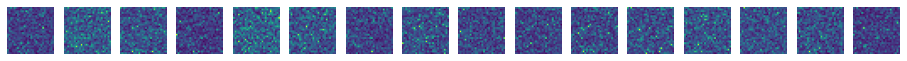

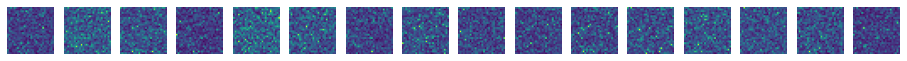

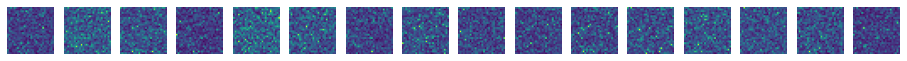

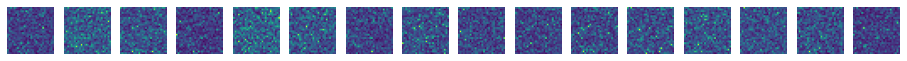

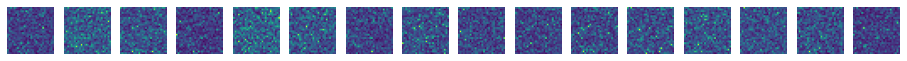

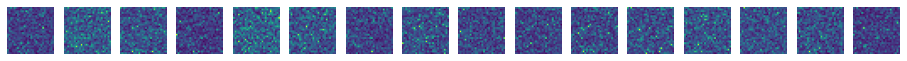

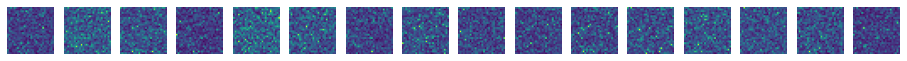

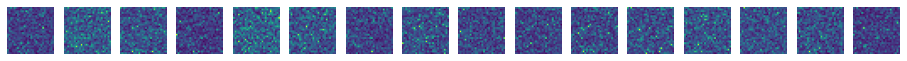

In [ ]:
num_examples_to_generate = 16
noise = tf.random.normal([num_examples_to_generate, n_noise])

buffer_size = 60000
epochs = 100

# 학습에 쓰일 데이터를 섞음
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

for epoch in range(epochs):
  for image_batch in train_dataset:
    train_step(image_batch)

  if epoch == 0 or (epoch + 1) % 10 == 0:
    generate_images(noise)

## 전체 코드

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

mnist = tf.keras.datasets.mnist

(x_train, _), (_, _) = mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255

#########
# 옵션 설정
######

n_hidden = 256
n_input = 28 * 28
n_noise = 128  # 생성기의 입력값으로 사용할 입력의 크기

batch_size = 100
learning_rate = 0.0002

buffer_size = 60000
epochs = 100

#########
# 신경망 모델 구성
######

# 생성기(G) 신경망
def generator():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(n_hidden, activation='relu', use_bias=True, input_shape=(n_noise,)),
    tf.keras.layers.Dense(n_input, activation='sigmoid', use_bias=True)
  ])

  return model

# 판별기(D) 신경망
def discriminator():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(n_hidden, activation='relu', use_bias=True, input_shape=(n_input,)),
    tf.keras.layers.Dense(1, activation='sigmoid', use_bias=True)
  ])

  return model

G = generator()
D = discriminator()

# G.summary()
# D.summary()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 생성기(G) 손실 함수
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

# 판별기(D) 손실 함수
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

# 최적화 설정
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)

#########
# 신경망 모델 학습
######

# 모델 학습 함수
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, n_noise])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = G(noise, training=True)

    real_output = D(images, training=True)
    fake_output = D(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, G.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, D.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, G.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, D.trainable_variables))

# 입력값에 대한 이미지 확인
def generate_images(test_input):
  input_size = len(test_input)
  predictions = G(test_input, training=False)

  fig = plt.figure(figsize=(input_size,1))
  for i in range(input_size):
    plt.subplot(1, input_size, i+1)
    plt.imshow(np.reshape(predictions[i], (28, 28)))
    plt.axis('off')

# 학습에 쓰일 데이터를 섞음
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

# 랜덤 입력값 생성
num_examples_to_generate = 16
noise = tf.random.normal([num_examples_to_generate, n_noise])

# 모델 학습 및 이미지 확인
for epoch in range(epochs):
  for image_batch in train_dataset:
    train_step(image_batch)

  if epoch == 0 or (epoch + 1) % 10 == 0:
    generate_images(noise)